#  In this project, we evaluate feature extraction in the RL filed

<table style="width:100%; table-layout:fixed;">
  <tr>
<td><img width="300px" src="images/images_overleaf/ant_better_reso.jpg"></td>

<td><img width="300px" src="images/images_overleaf/rl_explainde.png"></td>
<tr>
</table>



In [21]:
import os
from utils_lib.utils import Utils
import time
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import utils_lib.feature_extractor_layers as FeatureExtractorLayer
from utils_lib.all_feature import all_feature_extract as All_Features

from itertools import cycle
cycol = cycle('bgrcmk')
from scipy.signal import savgol_filter

utils = Utils()

size_ttt = 100


def test_layer(layer):
    time_t = np.array(np.linspace(0,1.0,size_ttt))
    time_t= torch.tensor([time_t]).type(torch.float64)
    result = layer(time_t)
    print(result.shape)
    plt.title("Features extraction by input projection")
    plt.xlabel("input value")
    plt.ylabel("output value.s")
    for i in range(result.shape[2]):
        plt.plot(result[0,:,i],label="neuron "+str(i))
    plt.legend()
    

def get_path(policie_name,env_name,fe_k,fev_l,index=0):
    global util
    #util.all_feature_extractor[]
    return os.path.join(os.getcwd(), ("./result/log_json/" +
    policie_name+ "/" +
    env_name+"/"+
    utils.all_feature_extractor[fe_k]["name"] + "_v" +
    str(utils.all_feature_extractor[fe_k]["order"][fev_l]) + "_i" +
    str(index) +".json"
    ))
def get_plot_array(path_log):
    data = []
    time = []
    with open(path_log, 'r') as fd:
        lines = fd.read().split('\n')
        for l in lines:
            split_array=l.split(",")
            if len(split_array)==5:
                #print(len(split_array))
                time.append(float(split_array[0]))
                data.append(float(split_array[2]))

    data = np.array(data)
    time = np.array(time)
    return data,time
def plot_array(data,error,time,plot_target,label_plot,color,marker):
    if color ==None:
        color=next(cycol)
        while color=="k":
            color=next(cycol)
    if hasattr(data, "__len__"):#
        if not(len(data) < 40 or len(time) <40):
            ti_li = savgol_filter(time, 40, 1)
            error = savgol_filter(error, 40, 1)
            data_li = savgol_filter(data, 40, 1)


            plot_target.plot(ti_li,data_li,label=label_plot,c=color, marker=marker,)
            plot_target.fill_between(ti_li,data_li-error,data_li+error,alpha=0.2,edgecolor=color, facecolor=color,)
            plot_target.legend()
            # plot_target.plot(ti_li,data_li-error)
            # plot_target.plot(ti_li,data_li+error)
def max_length(array):
    max_length=0
    for d in (array):
        max_length = max(max_length,len(d))
    return max_length
def get_array_of_size(array,m):
    for a in array:
        if len(a)==m:
            return a
def pad_mean(array):
    m = max_length(array)
    ref_array = get_array_of_size(array,m)
    for i in range(len(array)):
        index_to_fill = len(array[i])
        size_to_fill = m-len(array[i])
        array[i] = np.append(array[i],ref_array[index_to_fill:index_to_fill+size_to_fill])
    return array
def plot_one_file(plot_target,policy=None,env=None,fe_k=None,fe_v_k=None,label_plot="",color=None,marker=None,index=0,envs=utils.all_envs,policies=utils.all_policies):
    
    if not(hasattr(index, "__len__")):
        index=[index]

    policy = policies[policy]
    env = envs[env]
    data_final = []
    time_final = []
    for i in index:
        path_log = get_path(
            policie_name=policy["name"],
            env_name=env["name"],
            fe_k=fe_k,
            fev_l=fe_v_k,
            index=i)
        #print(path_log)
        if os.path.exists(path_log):
            #print("found")
            data,time = get_plot_array(path_log)
            data_final.append(data)
            time_final.append(time)



    # data_mean = np.mean(data_final, axis=0)
    # error_data = np.mean(np.abs(data_final-data_mean), axis=0)
    # time_final = np.mean(time_final, axis=0)

    data_mean = np.mean(pad_mean(data_final), axis=0)
    error_data = np.mean(np.abs(data_final-data_mean), axis=0)
    time_final = get_array_of_size(time_final,max_length(time_final))


    plot_array(data_mean,error_data,time_final,plot_target,label_plot,color,marker)




        
def plot_by_array(policy,env,fek,fev,index,label_plot=""):
    for i in policy:
        for j in env:
            for k in fek:
                for l in fev:  
                    if l < len(utils.all_feature_extractor[k]["order"]) :
                        if k==0:
                            plot_one_file(plt,i,j,k,l,label_plot=utils.all_feature_extractor[k]["name"]+"_"+str(utils.all_feature_extractor[k]["order"][l]),color="#000",index=index)
                        else:
                            plot_one_file(plt,i,j,k,l,label_plot=utils.all_feature_extractor[k]["name"]+"_"+str(utils.all_feature_extractor[k]["order"][l]),index=index)
    plt.grid()
    plt.legend()
def grid_plot_base(N_policie = 6,M_envs = 16,fek=[0],fev=[0],index_plt=[11011,11012,11013,11014,11015],envs=utils.all_envs,policies=utils.all_policies):
    M_envs = len(envs)
    N_policie = len(policies)
    
    fig, axs = plt.subplots(M_envs, N_policie, figsize=(N_policie*4,M_envs*3))
    for i,policy in enumerate(policies[:N_policie]):
        axs[0,i].set_title(policy["name"])  
    for ax in axs.flat:
        #ax.set(xlabel='timestep', ylabel='reward')
        ax.label_outer()


    for i,ax in enumerate(axs[:,0].flat):
        ax.set(ylabel=envs[i]["env"])

    for i in range(N_policie):
        for j in range(M_envs):
            for k in fek:
                for l in fev:  
                    if l < len(utils.all_feature_extractor[k]["order"]) :
                        if k==0:
                            plot_one_file(
                                axs[j,i],i,j,k,l,
                                label_plot=utils.all_feature_extractor[k]["name"]+"_"+str(utils.all_feature_extractor[k]["order"][l]),
                                color="#000",
                                index=index_plt,
                                envs=envs,
                                policies=policies
                                )
                    
                        else:
                            plot_one_file(
                                axs[j,i],i,j,k,l,
                                label_plot=utils.all_feature_extractor[k]["name"]+"_"+str(utils.all_feature_extractor[k]["order"][l]),
                                index=index_plt,
                                envs=envs,
                                policies=policies
                                )
    for i in range(N_policie):
        for j in range(M_envs):
            axs[j,i].grid()

    plt.show()
    return fig
    

# Feature extraction by activation function

We will project our input into activation function, and evaluate the gains for our RL agent

torch.Size([1, 100, 1])


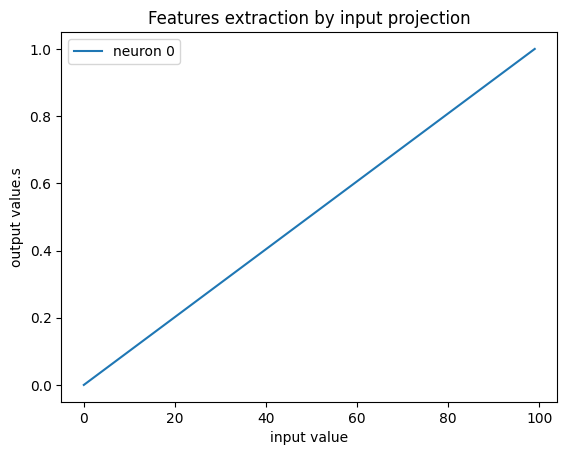

In [22]:
layer = FeatureExtractorLayer.NoneLayer
layer = layer(size_ttt,4,"cpu",True)
test_layer(layer)

# Result of the feature extraction

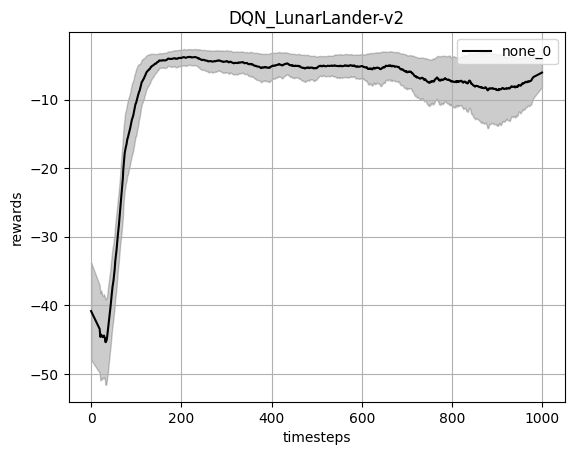

In [23]:
plt.figure(0)
env = 16
policy = 2
plt.title(utils.all_policies[policy]["name"]+"_"+utils.all_envs[env]["env"])
plt.xlabel("timesteps")
plt.ylabel("rewards")
plot_by_array([policy],[env],[0],[0],[11011,11012,11013,11014,11015])


# Finaly, we can evaluate almost everything in terms of Feature Extraction

torch.Size([1, 100, 9])


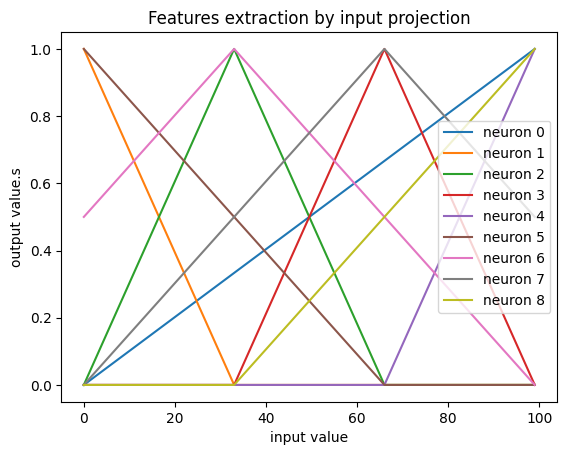

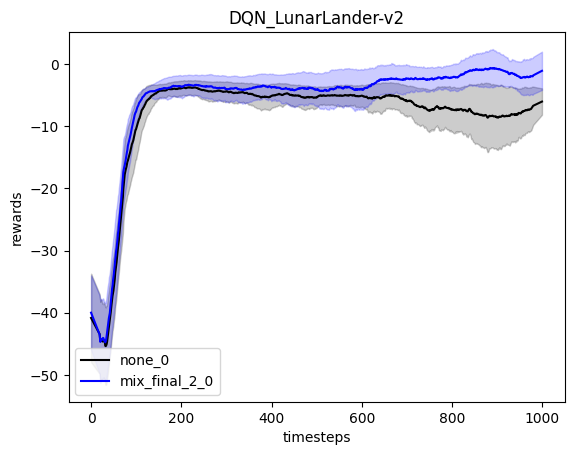

In [24]:


feature_extraction = 168

layer = All_Features[feature_extraction]["feature_layer"]
layer = layer(size_ttt,4,"cpu",True)
test_layer(layer)

plt.figure(0)
env = 16
policy = 2
plt.title(utils.all_policies[policy]["name"]+"_"+utils.all_envs[env]["env"])
plt.xlabel("timesteps")
plt.ylabel("rewards")
plot_by_array([policy],[env],[0],[0],[11011,11012,11013,11014,11015])
plot_by_array([policy],[env],[feature_extraction],[0],[11011,11012,11013,11014,11015])


# To show the result, we can plot environements and policies on the same grid

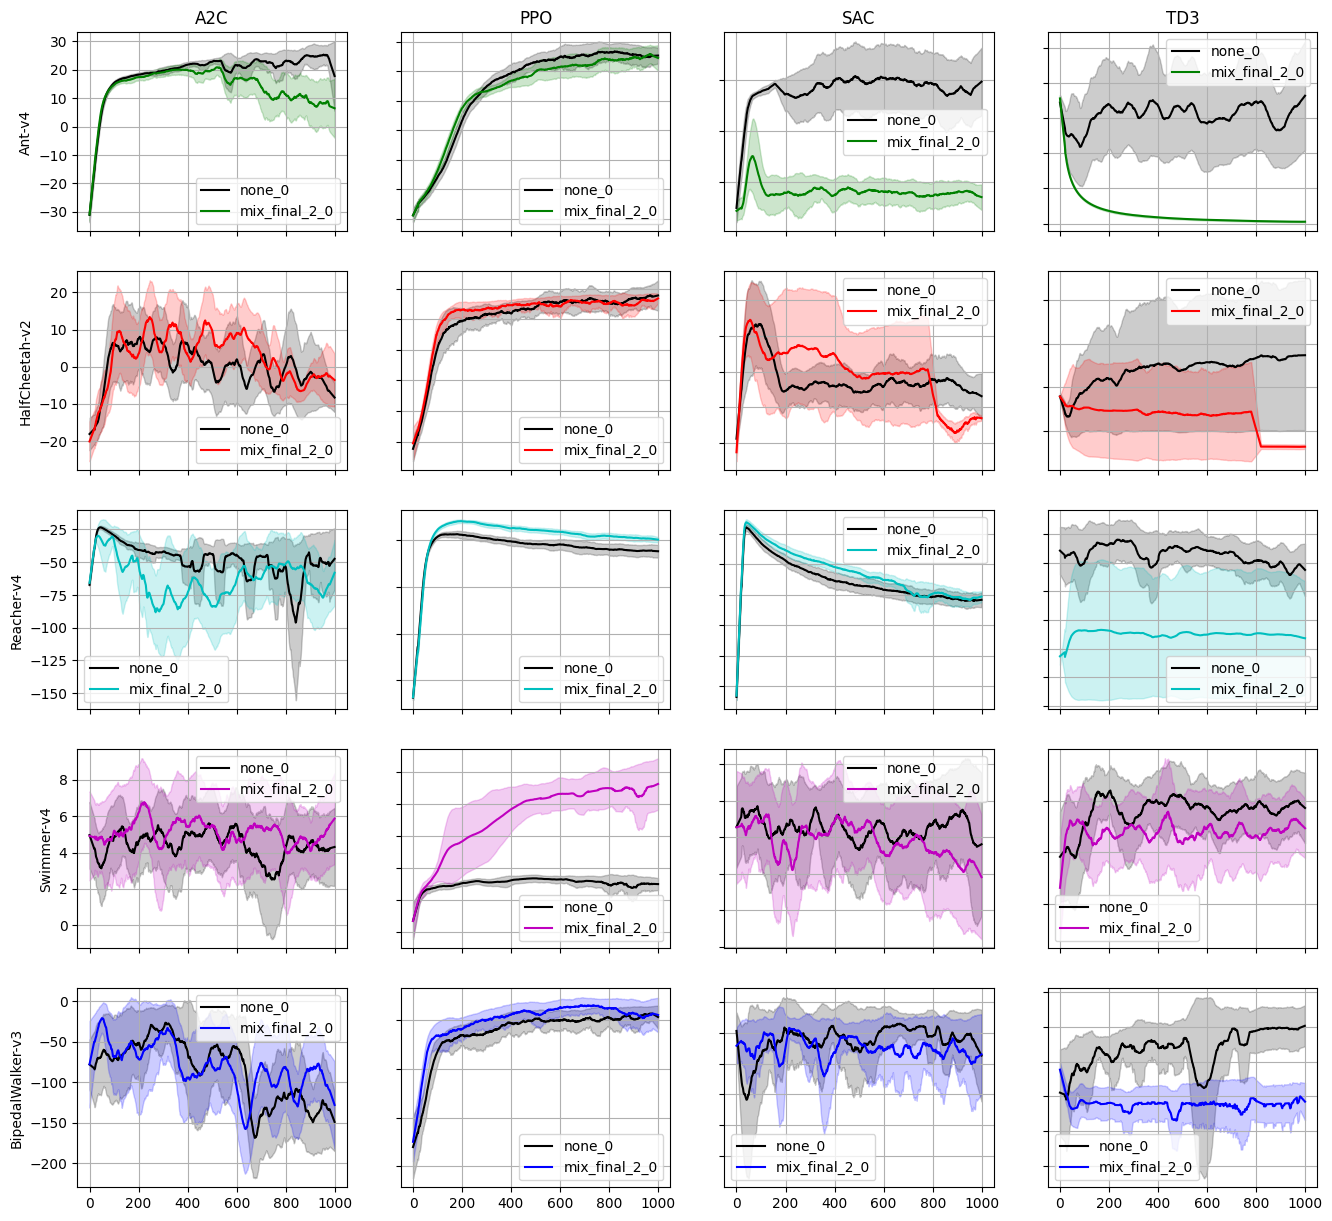

In [29]:
fig = grid_plot_base(
    envs=utils.all_envs_robotics,
    policies=utils.all_policies_robotics,
    fek=[0,168],fev=[0])